# NuClick:Interactive Annotation for Pathology

### Training Notebook

This tutorial uses a deep learning framework for interactive segmentation for microscopic images, the framework is referred to as NuClick [1]

NuClick uses only one point for delineating nuclei and cells and a squiggle for outlining glands. For nucleus and cell segmentation, proving a dot inside nucleus and cell is fast, easy, and does not require much effort from user compared to recent methods which rely on bounding boxes around objects. For glands, drawing a squiggle inside the
glands is not only much easier and user friendly for annotator but also gives more precise annotations compared to other methods. Our method is suitable for single object to full image segmentation and is applicable to a wide range of object scales, i.e. small nuclei to large glands [1].


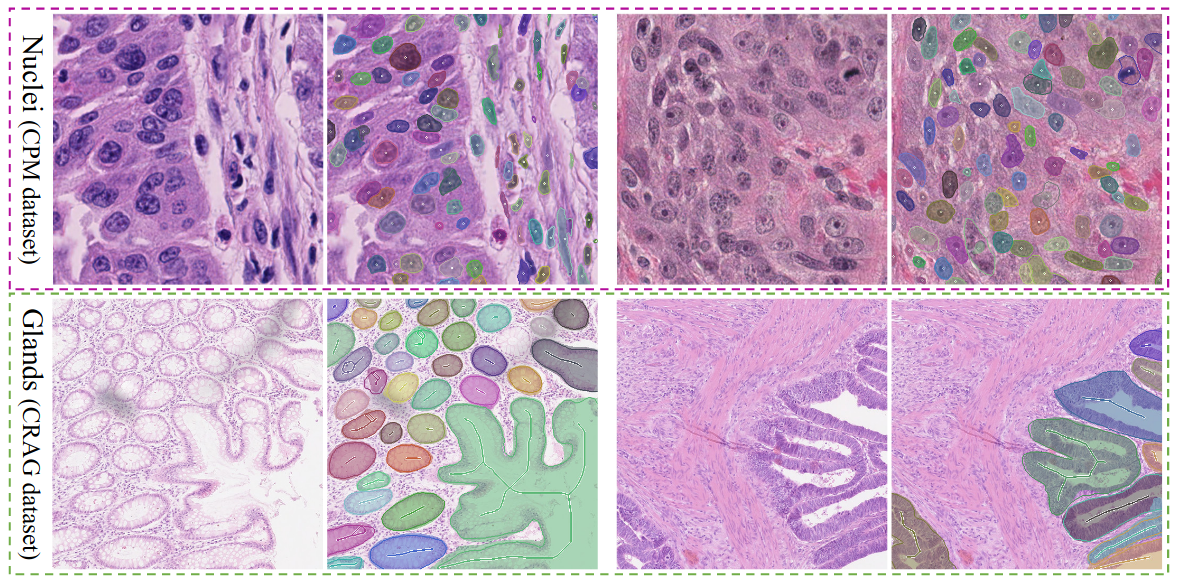
Generalizability of NuClick: The first row shows results of NuClick on CPM dataset for nuclei segmentation (where the network was trained on MoNuSeg dataset). The second row illustrates two samples of gland segmentation task from CRAG dataset where the model was trained on GLaS dataset. Solid stroke line around each object outlines the ground truth boundary for that object, overlaid transparent mask is the predicted segmentation region by NuClick, and points or squiggles indicate the provided guiding signal for interactive segmentation

### Features in the tutorial:
* Utilizes new transforms that were added for v0.9 of MONAI, the usage of the transforms in a training is shown in the tutorial:
    * FlattenLabeld
    * ExtractPatchd
    * SplitLabeld
    * AddPointGuidanceSignald
    * FilterImaged
* Data pre-processing functions, as typically pathology data is given as a whole slide, which cannot be directly used for training as it's too large in size, in particular check `split_pannuke_dataset`
* Uses the dataset: 

The PanNuke [2] dataset has a github page https://jgamper.github.io/PanNukeDataset/ and it can be downloaded from here: https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke

Please note that Fold 1 of the data is being used for the results shown in this tutorial

References:

[1] Koohbanani, Navid Alemi, et al. "NuClick: a deep learning framework for interactive segmentation of microscopic images." Medical Image Analysis 65 (2020): 101771.

[2] Gamper, Jevgenij, et al. "Pannuke: an open pan-cancer histology dataset for nuclei instance segmentation and classification." European congress on digital pathology. Springer, Cham, 2019.

In [1]:
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import tqdm" || pip install -q tqdm
%matplotlib inline

In [2]:
from monai.apps.nuclick.transforms import (
    FlattenLabeld,
    ExtractPatchd,
    SplitLabeld,
    AddPointGuidanceSignald,
    FilterImaged
)
from monai.transforms import (
    Activationsd,
    AddChanneld,
    AsChannelFirstd,
    AsDiscreted,
    Compose,
    EnsureTyped,
    LoadImaged,
    LoadImage,
    RandRotate90d,
    ScaleIntensityRangeD,
    ToNumpyd,
    TorchVisiond,
    ToTensord,
)
from monai.data import (
    Dataset,
    DataLoader,
)
from monai.networks.nets import BasicUNet
from monai.losses import DiceLoss
from monai.inferers import SimpleInferer
from monai.handlers import (
    CheckpointSaver,
    MeanDice,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
    ValidationHandler,
    from_engine
)
from monai.engines import SupervisedTrainer, SupervisedEvaluator
from skimage.measure import regionprops
import json
import copy
import math
import os
import numpy as np
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

/home/vishwesh/anaconda3/envs/nuclick_tutorial/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Configure Data Paths

Specify the paths where the data will be saved after pre-processing by configuring the following variable:



In [3]:
# Configure the downloaded PanNuke data path for the variable 'data_path'
raw_data_path = os.path.normpath('/scratch/pan_nuke_data/fold_1/Fold_1/')

img_data_path = os.path.join(raw_data_path, 'images/fold1/images.npy')
label_data_path = os.path.join(raw_data_path, 'masks/fold1/masks.npy')

# Set the log directory path, variable 'logging_dir', where processed-data will be saved, model checkpoints and tensorboard event files
logging_dir = os.path.normpath('/scratch/nuclick_experiments/test_trial/')

dataset_path = os.path.join(logging_dir, 'data')
json_path = os.path.join(logging_dir, 'data_list.json')

## Pre-processing utility functions

`split_pannuke_dataset` reads the raw provided numpy files of the PanNuke dataset. A single numpy file has the 2656 samples of 256x256 patch size with 5 labels. These are split into individual numpy files with binary pairs of image and mask, a json is also created. The 5 label split is as per the provided information of the dataset

`split_nuclei_dataset` for all the per label splits, there can be multiple nuclei in the given patch, this particular function provides the centroid of the image and also selects a single nuclei for a single training pair and the other nuclei get masked out

In [4]:
# Data Pre-processing Utility Functions
def split_pannuke_dataset(image, label, output_dir, groups):
    groups = groups if groups else dict()
    groups = [groups] if isinstance(groups, str) else groups
    if not isinstance(groups, dict):
        groups = {v: k + 1 for k, v in enumerate(groups)}

    label_channels = {
        0: "Neoplastic cells",
        1: "Inflammatory",
        2: "Connective/Soft tissue cells",
        3: "Dead Cells",
        4: "Epithelial",
    }

    print(f"++ Using Groups: {groups}")
    print(f"++ Using Label Channels: {label_channels}")

    images = np.load(image)
    labels = np.load(label)
    print(f"Image Shape: {images.shape}")
    print(f"Labels Shape: {labels.shape}")

    images_dir = output_dir
    labels_dir = os.path.join(output_dir, "labels", "final")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    dataset_json = []
    for i in tqdm(range(images.shape[0])):
        name = f"img_{str(i).zfill(4)}.npy"
        image_file = os.path.join(images_dir, name)
        label_file = os.path.join(labels_dir, name)

        image_np = images[i]
        mask = labels[i]
        label_np = np.zeros(shape=mask.shape[:2])

        for idx, name in label_channels.items():
            if idx < mask.shape[2]:
                m = mask[:, :, idx]
                if np.count_nonzero(m):
                    m[m > 0] = groups.get(name, 1)
                    label_np = np.where(m > 0, m, label_np)

        np.save(image_file, image_np)
        np.save(label_file, label_np)
        dataset_json.append({"image": image_file, "label": label_file})

    return dataset_json


def split_nuclei_dataset(d, centroid_key="centroid", mask_value_key="mask_value", min_area=5):
    dataset_json = []

    mask = LoadImage(image_only=True, dtype=np.uint8)(d["label"])
    _, labels, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

    stats = regionprops(labels)
    for stat in stats:
        if stat.area < min_area:
            print(f"++++ Ignored label with smaller area => ( {stat.area} < {min_area})")
            continue

        x, y = stat.centroid
        x = int(math.floor(x))
        y = int(math.floor(y))

        item = copy.deepcopy(d)
        item[centroid_key] = (x, y)
        item[mask_value_key] = stat.label

        dataset_json.append(item)
    return dataset_json

## Create Json, form training and validation split

`split_pannuke_dataset` and `split_nuclei_dataset` break the dataset into a total of 53,413 training samples. We use a 80/20 split for training and validating the model

In [5]:
groups = [
    "Neoplastic cells",
    "Inflammatory",
    "Connective/Soft tissue cells",
    "Dead Cells",
    "Epithelial",
]

# Hyper-params
patch_size = 128
min_area = 5

# Create Dataset
if os.path.isfile(json_path) == 0:
    dataset_json = split_pannuke_dataset(image=img_data_path,
                                         label=label_data_path,
                                         output_dir=dataset_path,
                                         groups=groups)

    with open(json_path, 'w') as j_file:
        json.dump(dataset_json, j_file)
    j_file.close()

else:
    with open(json_path, 'r') as j_file:
        dataset_json = json.load(j_file)
    j_file.close()

ds_json_new = []
for d in tqdm(dataset_json):
    ds_json_new.extend(split_nuclei_dataset(d, min_area=min_area))

print('Total DataSize is {}'.format(len(ds_json_new)))
val_split = round(len(ds_json_new) * 0.8)
train_ds_json_new = ds_json_new[:val_split]
val_ds_json_new = ds_json_new[val_split:]

  3%|█▎                                      | 87/2656 [00:00<00:05, 430.00it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)


  7%|██▌                                    | 173/2656 [00:00<00:06, 397.73it/s]

++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 10%|███▋                                   | 254/2656 [00:00<00:06, 386.06it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)


 13%|████▉                                  | 333/2656 [00:00<00:05, 387.59it/s]

++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)


 16%|██████▏                                | 425/2656 [00:01<00:05, 421.58it/s]

++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 19%|███████▌                               | 514/2656 [00:01<00:04, 429.15it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 24%|█████████▌                             | 647/2656 [00:01<00:04, 428.12it/s]

++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)


 28%|██████████▊                            | 739/2656 [00:01<00:04, 433.33it/s]

++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 31%|████████████▏                          | 828/2656 [00:01<00:04, 432.59it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 34%|█████████████▍                         | 914/2656 [00:02<00:04, 392.11it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)


 37%|██████████████▌                        | 993/2656 [00:02<00:04, 348.89it/s]

++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)


 40%|███████████████▎                      | 1070/2656 [00:02<00:04, 330.58it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)


 44%|████████████████▋                     | 1165/2656 [00:02<00:03, 399.56it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 49%|██████████████████▋                   | 1307/2656 [00:03<00:03, 434.73it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 52%|███████████████████▉                  | 1394/2656 [00:03<00:03, 416.87it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)


 56%|█████████████████████▏                | 1483/2656 [00:03<00:02, 404.87it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)


 60%|██████████████████████▋               | 1582/2656 [00:03<00:02, 428.42it/s]

++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 63%|███████████████████████▉              | 1671/2656 [00:04<00:02, 432.65it/s]

++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)


 67%|█████████████████████████▎            | 1769/2656 [00:04<00:02, 419.12it/s]

++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 70%|██████████████████████████▌           | 1853/2656 [00:04<00:02, 397.28it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 74%|███████████████████████████▉          | 1957/2656 [00:04<00:01, 452.27it/s]

++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 77%|█████████████████████████████▍        | 2055/2656 [00:04<00:01, 468.57it/s]

++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)


 81%|██████████████████████████████▊       | 2152/2656 [00:05<00:01, 459.65it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 3 < 5)


 85%|████████████████████████████████▏     | 2246/2656 [00:05<00:00, 444.67it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)


 88%|█████████████████████████████████▍    | 2335/2656 [00:05<00:00, 413.55it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 91%|██████████████████████████████████▌   | 2420/2656 [00:05<00:00, 339.17it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


 94%|███████████████████████████████████▋  | 2498/2656 [00:06<00:00, 341.11it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 2 < 5)


 97%|████████████████████████████████████▉ | 2579/2656 [00:06<00:00, 368.18it/s]

++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)


100%|██████████████████████████████████████| 2656/2656 [00:06<00:00, 401.04it/s]

++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 1 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 2 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 4 < 5)
++++ Ignored label with smaller area => ( 3 < 5)
Total DataSize is 53413


## Training & Validation Transforms

In [6]:
# Transforms
train_pre_transforms = Compose(
    [
        LoadImaged(keys=("image", "label"), dtype=np.uint8),
        FilterImaged(keys="image", min_size=5),
        FlattenLabeld(keys="label"),
        AsChannelFirstd(keys="image"),
        AddChanneld(keys="label"),
        ExtractPatchd(keys=("image", "label"), patch_size=patch_size),
        SplitLabeld(keys="label", others="others", mask_value="mask_value", min_area=min_area),
        ToTensord(keys="image"),
        TorchVisiond(
            keys="image", name="ColorJitter", brightness=64.0 / 255.0, contrast=0.75, saturation=0.25, hue=0.04
        ),
        ToNumpyd(keys="image"),
        RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
        AddPointGuidanceSignald(image="image", label="label", others="others"),
        EnsureTyped(keys=("image", "label"))
    ])

train_post_transforms = Compose([
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold_values=True, logit_thresh=0.5),
]
)

val_transforms = Compose(
    [
        LoadImaged(keys=("image", "label"), dtype=np.uint8),
        FilterImaged(keys="image", min_size=5),
        FlattenLabeld(keys="label"),
        AsChannelFirstd(keys="image"),
        AddChanneld(keys="label"),
        ExtractPatchd(keys=("image", "label"), patch_size=patch_size),
        SplitLabeld(keys="label", others="others", mask_value="mask_value", min_area=min_area),
        ToTensord(keys="image"),
        TorchVisiond(
            keys="image", name="ColorJitter", brightness=64.0 / 255.0, contrast=0.75, saturation=0.25, hue=0.04
        ),
        ToNumpyd(keys="image"),
        RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
        AddPointGuidanceSignald(image="image", label="label", others="others", drop_rate=1.0),
        EnsureTyped(keys=("image", "label"))
    ]
)

`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


## NuClick Transforms Testing

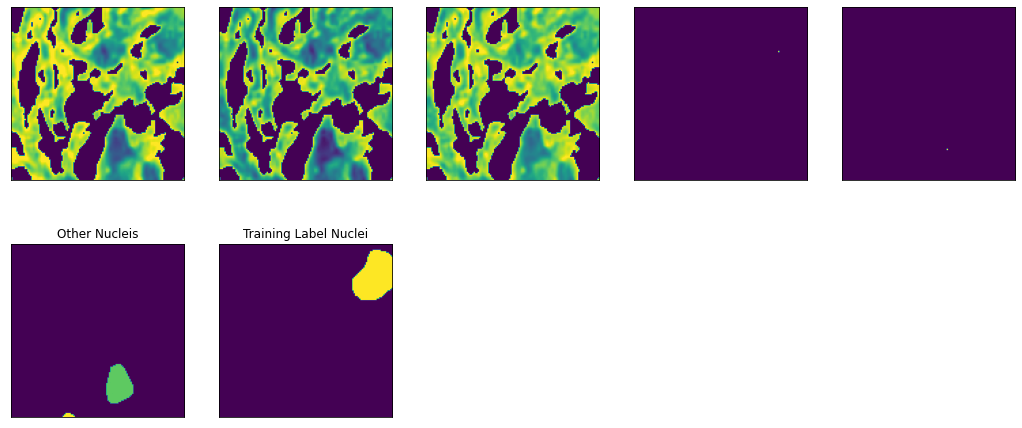

In [7]:
# Showcase the use of FilterImaged & FlattenLabeld

showcase_ds = ds_json_new[25:32]

show_usage_transforms = Compose([
    LoadImaged(keys=("image", "label"), dtype=np.uint8),
    FilterImaged(keys="image", min_size=5),
    FlattenLabeld(keys="label"),
    AsChannelFirstd(keys="image"),
    AddChanneld(keys="label"),
])

show_data_set = Dataset(train_ds_json_new, transform=train_pre_transforms)

show_data_loader = DataLoader(
    dataset=show_data_set,
    batch_size=1,
    shuffle=False,
)

for show_idx, show_batch in enumerate(show_data_loader):
    for img_plt in range(1, 6):
        plt.subplot(2, 5, img_plt)
        plt.imshow(np.squeeze(show_batch['image'][0, img_plt - 1, :, :]))
        plt.xticks([])
        plt.yticks([])

    plt.subplot(2, 5, 6)
    plt.imshow(np.squeeze(show_batch['others']))
    plt.xticks([])
    plt.yticks([])
    plt.title('Other Nucleis')
    plt.subplot(2, 5, 7)
    plt.imshow(np.squeeze(show_batch['label']))
    plt.xticks([])
    plt.yticks([])
    plt.title('Training Label Nuclei')
    plt.show()
    break

## Training of NuClick Model

In [8]:
train_key_metric = {"train_dice": MeanDice(
    include_background=False, output_transform=from_engine(["pred", "label"]))}
val_key_metric = {"val_dice": MeanDice(include_background=False, output_transform=from_engine(["pred", "label"]))}
val_inferer = SimpleInferer()

# Define Dataset & Loading
train_data_set = Dataset(train_ds_json_new, transform=train_pre_transforms)
train_data_loader = DataLoader(dataset=train_data_set, batch_size=32, shuffle=True, num_workers=2)

val_data_set = Dataset(val_ds_json_new, transform=val_transforms)
val_data_loader = DataLoader(dataset=val_data_set, batch_size=32, shuffle=True, num_workers=2)

# Network Definition, Optimizer etc
device = torch.device("cuda")

network = BasicUNet(spatial_dims=2, in_channels=5, out_channels=1, features=(32, 64, 128, 256, 512, 32))

network.to(device)
optimizer = torch.optim.Adam(network.parameters(), 0.0001)
dice_loss = DiceLoss(sigmoid=True, squared_pred=True)

# Training Process
val_handlers = [
    # use the logger "train_log" defined at the beginning of this program
    StatsHandler(name="train_log", output_transform=lambda x: None),
    TensorBoardStatsHandler(log_dir=logging_dir, output_transform=lambda x: None),
    TensorBoardImageHandler(
        log_dir=logging_dir,
        batch_transform=from_engine(["image", "label"]),
        output_transform=from_engine(["pred"]),
    ),
    CheckpointSaver(save_dir=logging_dir, save_dict={"network": network}, save_key_metric=True),
]

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_data_loader,
    network=network,
    inferer=val_inferer,
    postprocessing=train_post_transforms,
    key_val_metric=val_key_metric,
    val_handlers=val_handlers,
    # if no FP16 support in GPU or PyTorch version < 1.6, will not enable AMP evaluation
    amp=False,
)

train_handlers = [
    ValidationHandler(validator=evaluator, interval=1, epoch_level=True),
    # use the logger "train_log" defined at the beginning of this program
    StatsHandler(name="train_log",
                 tag_name="train_loss",
                 output_transform=from_engine(["loss"], first=True)),
    TensorBoardStatsHandler(log_dir=logging_dir,
                            tag_name="train_loss",
                            output_transform=from_engine(["loss"], first=True)
                            ),
    CheckpointSaver(save_dir=logging_dir,
                    save_dict={"net": network, "opt": optimizer},
                    save_interval=1,
                    epoch_level=True),
]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=30,
    train_data_loader=train_data_loader,
    network=network,
    optimizer=optimizer,
    loss_function=dice_loss,
    inferer=SimpleInferer(),
    # if no FP16 support in GPU or PyTorch version < 1.6, will not enable AMP evaluation
    amp=False,
    postprocessing=train_post_transforms,
    key_train_metric=train_key_metric,
    train_handlers=train_handlers,
)
trainer.run()

BasicUNet features: (32, 64, 128, 256, 512, 32).


the effective log level of engine logger or RootLogger is higher than INFO, may not record log, please call `logging.basicConfig(stream=sys.stdout, level=logging.INFO)` to enable it.


The results can be visualizaed by passing the logging_dir variable path to tensorboard. For e.g
`tensorboard --logdir=\path\as\set\for\variable\logging_dir`

An example visualization is shown for the trained model using the framework provided above.

The plots show the training and validation Dice scores for the training process. The best validation Dice score achieved is ~0.84

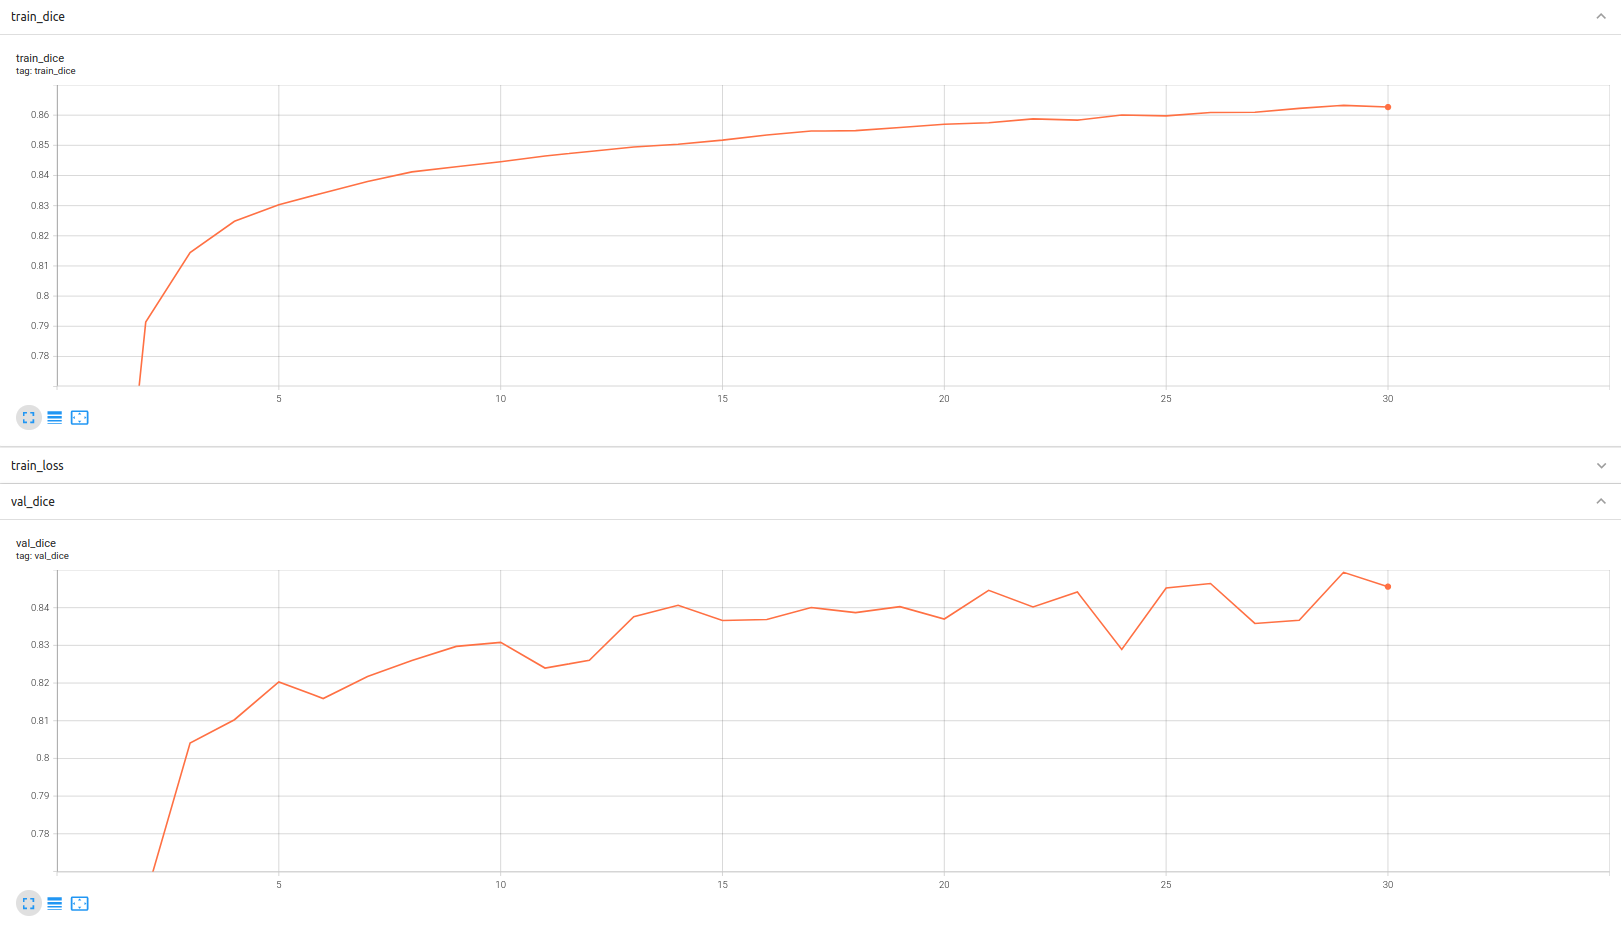

## End of Notebook